# GPU Test

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Dec 17 02:28:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# VM Test

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


# Mount Google Drive

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cd "/content/drive/My Drive/OCRTraining/PassportDataset/synthetic_passports"

In [ ]:
# To list the number of passport data that has been configured
!ls drive/My\ Drive/OCRTraining/PassportDataset/synthetic_passports

labels.txt	   passport_1901.jpg   vpassport_1004.jpg  vpassport_1904.jpg  vpassport_2804.jpg
passport_1000.jpg  passport_1902.jpg   vpassport_1005.jpg  vpassport_1905.jpg  vpassport_2805.jpg
passport_1001.jpg  passport_1903.jpg   vpassport_1006.jpg  vpassport_1906.jpg  vpassport_2806.jpg
passport_1002.jpg  passport_1904.jpg   vpassport_1007.jpg  vpassport_1907.jpg  vpassport_2807.jpg
passport_1003.jpg  passport_1905.jpg   vpassport_1008.jpg  vpassport_1908.jpg  vpassport_2808.jpg
passport_1004.jpg  passport_1906.jpg   vpassport_1009.jpg  vpassport_1909.jpg  vpassport_2809.jpg
passport_1005.jpg  passport_1907.jpg   vpassport_100.jpg   vpassport_190.jpg   vpassport_280.jpg
passport_1006.jpg  passport_1908.jpg   vpassport_1010.jpg  vpassport_1910.jpg  vpassport_2810.jpg
passport_1007.jpg  passport_1909.jpg   vpassport_1011.jpg  vpassport_1911.jpg  vpassport_2811.jpg
passport_1008.jpg  passport_190.jpg    vpassport_1012.jpg  vpassport_1912.jpg  vpassport_2812.jpg
passport_1009.jpg  passpor

In [ ]:
# To list the number of passport data that has been configured
!ls drive/My\ Drive/OCRTraining/PassportDataset/mutated_passports

vpassport_3001.jpg


# Import Font Configs

In [ ]:
# Install wget to download the font
!apt-get install -y wget

# Download Arial font and move it to a fonts directory
!wget -O arial.ttf "https://fonts.gstatic.com/s/roboto/v30/KFOlCnqEu92Fr1MmEU9fBBc9.ttf"


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
wget is already the newest version (1.21.2-2ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
--2024-12-17 04:21:04--  https://fonts.gstatic.com/s/roboto/v30/KFOlCnqEu92Fr1MmEU9fBBc9.ttf
Resolving fonts.gstatic.com (fonts.gstatic.com)... 74.125.195.94, 2607:f8b0:400e:c0a::5e
Connecting to fonts.gstatic.com (fonts.gstatic.com)|74.125.195.94|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36460 (36K) [font/ttf]
Saving to: ‘arial.ttf’

arial.ttf           100%[===================>]  35.61K  --.-KB/s    in 0.001s  

2024-12-17 04:21:04 (44.5 MB/s) - ‘arial.ttf’ saved [36460/36460]



# Import Libraries

In [ ]:
!pip install pillow
!pip install faker
!pip install opencv-python-headless

# 2000 Standard Synthetic Passport Generation (any language)

In [ ]:
# Using pre-set label and standard passport image background, blurred box to be changed
# annotated with {[x1,y1], [x2,y2], [x3,y3], [x4,y4]} positions
# then generate synthetic data using faker into those selective fields

# STEP 1: Assert locations that need to be changed with according data output
from PIL import Image, ImageDraw, ImageFont
from faker import Faker
import random
import os
import cv2
import numpy as np
import json
from multiprocessing import Pool
import requests
import zipfile

# Initialize Faker and paths
fake = Faker()
root_path = "/content/drive/My Drive/OCRTraining/PassportDataset"
output_folder = os.path.join(root_path, "synthetic_passports")
label_file = os.path.join(output_folder, "labels.txt")
template_image_path = os.path.join(output_folder, "template/passport_template.png")
template_json_path = os.path.join(output_folder, "template/passport_template.json")
font_path = os.path.join(root_path, "DejaVuSans-Bold.ttf")
font_zip_url = "https://github.com/dejavu-fonts/dejavu-fonts/releases/download/version_2_37/dejavu-fonts-ttf-2.37.zip"

os.makedirs(output_folder, exist_ok=True)

# Function to download and extract font
def download_font():
    if not os.path.exists(font_path):
        print("Font not found. Downloading...")
        response = requests.get(font_zip_url, stream=True)
        if response.status_code == 200:
            with open("dejavu-fonts.zip", 'wb') as f:
                f.write(response.content)
            with zipfile.ZipFile("dejavu-fonts.zip", 'r') as zip_ref:
                zip_ref.extractall(root_path)
            os.rename(
                os.path.join(root_path, "dejavu-fonts-ttf-2.37/ttf/DejaVuSans-Bold.ttf"),
                font_path
            )
        else:
            raise ConnectionError("Failed to download font file.")


# STEP 2: Define logics for synthetic data
# nameid section is formatted as VMNYOUR<FULL<Name<
def generate_nameid(fullname):
    return "VNM" + "<".join(fullname.upper().split()) + "<"

def generate_fields():
    fullname = fake.name()
    nationality = fake.country()
    dob = fake.date_of_birth(minimum_age=18, maximum_age=65).strftime("%d/%m/%Y")
    sex = random.choice(["Nam/M", "Nữ/F"])
    pob = f"{fake.city()}, {fake.country()}"
    cmnd = str(random.randint(100000000, 999999999))
    passportid = f"{random.choice('ABCDEFGHIJKLMNOPQRSTUVWXYZ')}{random.randint(1000000, 9999999)}"
    nameid = generate_nameid(fullname)
    # Debug print to ensure fields are generated
    print({
        "fullname": fullname,
        "nationality": nationality,
        "dob": dob,
        "sex": sex,
        "pob": pob,
        "cmnd": cmnd,
        "passportid": passportid,
        "nameid": nameid,
        "passportid2": passportid
    })
    # Return faked data to be saved
    return {
        "fullname": fullname,
        "nationality": nationality,
        "dob": dob,
        "sex": sex,
        "pob": pob,
        "cmnd": cmnd,
        "passportid": passportid,
        "nameid": nameid,
        "passportid2": passportid
    }

# Convert position coordination from labelme annotation to bbox for text writing
def extract_bbox(points):
    """
    Convert a list of polygon points into a bounding box (x1, y1, x2, y2).
    Assumes points are provided as [[x1, y1], [x2, y2], ...].
    """
    x_coords = [p[0] for p in points]
    y_coords = [p[1] for p in points]
    return min(x_coords), min(y_coords), max(x_coords), max(y_coords)

# Allocate appropriate position for the text to be placed
def place_text(draw, text, bbox, font):
    """
    Place text centered within the bounding box.
    """
    x1, y1, x2, y2 = bbox
    # w, h = draw.textsize(text, font=font)
    # In the latest versions of Pillow (>= 10.0), textbbox is preferred as it provides a bounding box for the text.
    # So we shouldn't use textsize as it could possibly overlapping the bbox configured
    bbox = draw.textbbox((0, 0), text, font=font)
    w, h = bbox[2] - bbox[0], bbox[3] - bbox[1]
    # Center the text in within the bbox
    x = x1 + (x2 - x1 - w) / 2  # Center horizontally
    y = y1 + (y2 - y1 - h) / 2  # Center vertically
    draw.text((x, y), text, fill=(0, 0, 0), font=font)

# Init empty list of results for later collection
results = []

# STEP 4: Write the faked data into selective fields, converting json regions to bbox
def generate_passport(index):
    try:
        # Load template JSON regions
        with open(template_json_path, 'r') as f:
            regions_data = json.load(f)
            regions = {shape["label"]: extract_bbox(shape["points"])
                       for shape in regions_data.get("shapes", [])}

        # Load background and initialize drawing
        background = cv2.imread(template_image_path)
        img = Image.fromarray(cv2.cvtColor(background, cv2.COLOR_BGR2RGB))
        draw = ImageDraw.Draw(img)
        font = ImageFont.truetype(font_path, size=24)

        # Generate fake data fields
        fields = generate_fields()

        # Draw fields based on JSON regions
        for label, text in fields.items():
            if label in regions:
                bbox = regions[label]  # Retrieve bbox for label
                print(f"Placing '{label}': {text} at {bbox}")
                place_text(draw, text, bbox, font)
            else:
                print(f"Warning: Missing or invalid points for label '{label}'")

        # Save image
        img_path = os.path.join(output_folder, f"passport_{index}.jpg")
        img.save(img_path)

        # Collect path and fields generated from fake data into the result list
        results.append({"path": img_path, "fields": fields})

        # Add noise
        # img_cv = cv2.imread(img_path)
        # noise = np.random.normal(0, 15, img_cv.shape).astype(np.uint8)
        # img_cv = cv2.add(img_cv, noise)
        # cv2.imwrite(img_path, img_cv)
        '''
        The addition of noise in the output image was likely included for simulating real-world imperfections such as:
          - Scanned document artifacts
          - Printing distortions
          - Image sensor noise in photos
        Comment when not needed
        '''
        # Save labels
        with open(label_file, "a") as lf:
            lf.write(f"{img_path}|{json.dumps(fields)}\n")

    except Exception as e:
        print(f"Error generating passport {index}: {e}")

# Main
if __name__ == "__main__":
    download_font()
    num_samples = 5000 # The number of faked sample to be generated, change this as the size of volume demanded
    with open(label_file, "w") as lf:
        lf.write("Image_Path|Fields\n")  # Write file header
    # Start multiprocessing
    with Pool(processes=8) as pool:
        pool.map(generate_passport, range(1, num_samples + 1)) # Indexing from i (1) to n+1
    print("Synthetic passport generation complete!")

Streaming output truncated to the last 5000 lines.
Placing 'dob': 18/02/1986 at (655.7142857142857, 1111.4285714285713, 828.5714285714284, 1137.142857142857)


Placing 'pob': South Cindyfort, Senegal at (965.7142857142857, 1107.142857142857, 1114.2857142857142, 1140.0)Placing 'cmnd': 200096858 at (962.8571428571428, 1174.2857142857142, 1090.0, 1198.5714285714284)Placing 'passportid2': C7712628 at (362.85714285714283, 1421.4285714285713, 525.7142857142857, 1455.7142857142856)Placing 'sex': Nữ/F at (659.9999999999999, 1174.2857142857142, 779.9999999999999, 1204.2857142857142)

Placing 'pob': South Cindyfort, Senegal at (965.7142857142857, 1107.142857142857, 1114.2857142857142, 1140.0)
Placing 'passportid': M8695973 at (1011.4285714285713, 959.9999999999999, 1144.2857142857142, 989.9999999999999)

Placing 'cmnd': 109847799 at (962.8571428571428, 1174.2857142857142, 1090.0, 1198.5714285714284)
Placing 'cmnd': 688227004 at (962.8571428571428, 1174.2857142857142, 1090.0, 1198.5714285714284)


'\nThe set of data could be split into different sectional sectors:\n- Blurred: Add noise to simulate out-worn physical passport\n- Angled: Place the passport in a diagonal direction, not necessarily being in any fixed angle (i.e., right angled)\n- Brightening: Under or over lighting or shadowing the image could simulate real-life light situation of the passport can be imperfect\n- Vietnamese: Specialized for VietOCR which can detect and generate Vietnamese character with tonal symbols\n- Handwriting: Edge case where it could handle hand writing text\n'

# Remove Excessive Images to save GD storage

In [ ]:
import os

# Path to the folder containing the generated passport images
# output_folder = "/content/drive/My Drive/OCRTraining/PassportDataset/synthetic_passports" # Sample original synthetics
output_folder = "/content/drive/My Drive/OCRTraining/PassportDataset/mutated_passports"   # Sample processed mutants

# Define the range of image files to delete
start_index = 1  # First file from index to be deleted
end_index = 3000 # Last file from index to be deleted

# Loop through the range and delete matching files
for index in range(start_index, end_index + 1):
    # file_name = f"passport_{index}.jpg"   # For generic passport
    file_name = f"vpassport_{index}.jpg" # For Vietnamese passport
    file_path = os.path.join(output_folder, file_name)

    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"Deleted: {file_path}")
    else:
        print(f"File not found: {file_path}")

print("Deletion process complete!")


File not found: /content/drive/My Drive/OCRTraining/PassportDataset/mutated_passports/vpassport_3000.jpg
Deleted: /content/drive/My Drive/OCRTraining/PassportDataset/mutated_passports/vpassport_3001.jpg
Deletion process complete!


# Test Vietnamese Font import with Patric Hand

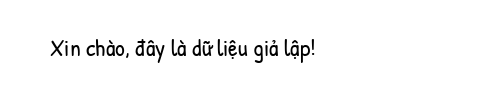

In [ ]:
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display
import os

# Path to the handwriting font
root_path = "/content/drive/My Drive/OCRTraining/PassportDataset"
font_path = os.path.join(root_path, "patrick_hand_font/PatrickHand-Regular.ttf")

# Verify the font path exists
assert os.path.exists(font_path), f"Font not found at {font_path}"

# Load the font with fallback
try:
    font = ImageFont.truetype(font_path, size=24)
except Exception as e:
    print(f"Failed to load font: {e}. Falling back to default font.")
    font = ImageFont.load_default()

# Create a test image
img = Image.new("RGB", (500, 100), color=(255, 255, 255))
draw = ImageDraw.Draw(img)
draw.text((50, 30), "Xin chào, đây là dữ liệu giả lập!", font=font, fill=(0, 0, 0))

# Display the image
display(img)

# 3000 Vietnamese both Printed and Handwritten Synthetic Passports

In [ ]:
# Using pre-set label and standard passport image background, blurred box to be changed
# annotated with {[x1,y1], [x2,y2], [x3,y3], [x4,y4]} positions
# then generate synthetic data using faker into those selective fields

# STEP 1: Assert locations that need to be changed with according data output
from PIL import Image, ImageDraw, ImageFont
import random
import os
import cv2
import numpy as np
import json
from faker import Faker
from multiprocessing import Pool
import requests
import zipfile

# Initialize Faker and paths
fake = Faker()
root_path = "/content/drive/My Drive/OCRTraining/PassportDataset"
output_folder = os.path.join(root_path, "synthetic_passports")
label_file = os.path.join(output_folder, "labels.txt")
template_image_path = os.path.join(output_folder, "template/passport_template.png")
template_json_path = os.path.join(output_folder, "template/passport_template.json")
font_path = os.path.join(root_path, "DejaVuSans-Bold.ttf")
font_zip_url = "https://github.com/dejavu-fonts/dejavu-fonts/releases/download/version_2_37/dejavu-fonts-ttf-2.37.zip"

os.makedirs(output_folder, exist_ok=True)

# Function to download and extract font
def download_font():
    if not os.path.exists(font_path):
        print("Font not found. Downloading...")
        response = requests.get(font_zip_url, stream=True)
        if response.status_code == 200:
            with open("dejavu-fonts.zip", 'wb') as f:
                f.write(response.content)
            with zipfile.ZipFile("dejavu-fonts.zip", 'r') as zip_ref:
                zip_ref.extractall(root_path)
            os.rename(
                os.path.join(root_path, "dejavu-fonts-ttf-2.37/ttf/DejaVuSans-Bold.ttf"),
                font_path
            )
        else:
            raise ConnectionError("Failed to download font file.")


# STEP 2: Define logics for synthetic data
# nameid section is formatted as VMNYOUR<FULL<Name<
def generate_nameid(fullname):
    return "VNM" + "<".join(fullname.upper().split()) + "<"

# Vietnamese vocabularies listing
vietnamese_vocab = "aAàÀảẢãÃáÁạẠăĂằẰẳẲẵẴắẮặẶâÂầẦẩẨẫẪấẤậẬbBcCdDđĐeEèÈẻẺẽẼéÉẹẸêÊềỀểỂễỄếẾệỆfFgGhHiIìÌỉỈĩĨíÍịỊjJkKlLmMnNoOòÒỏỎõÕóÓọỌôÔồỒổỔỗỖốỐộỘơƠờỜởỞỡỠớỚợỢpPqQrRsStTuUùÙủỦũŨúÚụỤưƯừỪửỬữỮứỨựỰvVwWxXyYỳỲỷỶỹỸýÝỵỴzZ"

# Randomly picking Vietnamese name from the set of vocabs, without specifically need to set a meaning
def generate_vietnamese_text(length=10):
    """
    Generate random Vietnamese text using the VietOCR vocab.
    """
    return "".join(random.choice(vietnamese_vocab) for _ in range(length))

# Define faking rule
def generate_fields_vietnamese(is_handwritten=False):
    """
    Generate Vietnamese fields for passports.
    Handwritten data is generated using handwriting-like fonts.
    """
    fullname = generate_vietnamese_text(12)   # E.g. Name can be 12 characters
    nationality = generate_vietnamese_text(8) # E.g. Country can be 8 characters
    pob = generate_vietnamese_text(15)        # E.g. POB can be 15 characters
    dob = fake.date_of_birth(minimum_age=18, maximum_age=65).strftime("%d/%m/%Y")
    sex = random.choice(["Nam/M", "Nữ/F"])
    cmnd = str(random.randint(100000000, 999999999))
    passportid = f"{random.choice('ABCDEFGHIJKLMNOPQRSTUVWXYZ')}{random.randint(1000000, 9999999)}"
    nameid = generate_nameid(fullname)

    return {
        "fullname": fullname,
        "nationality": nationality,
        "pob": pob,
        "dob": dob,
        "sex": sex,
        "cmnd": cmnd,
        "passportid": passportid,
        "nameid": nameid,
        "passportid2": passportid
    }

# Convert position coordination from labelme annotation to bbox for text writing
def extract_bbox(points):
    """
    Convert a list of polygon points into a bounding box (x1, y1, x2, y2).
    Assumes points are provided as [[x1, y1], [x2, y2], ...].
    """
    x_coords = [p[0] for p in points]
    y_coords = [p[1] for p in points]
    return min(x_coords), min(y_coords), max(x_coords), max(y_coords)

# Allocate appropriate position for the text to be placed
def place_text(draw, text, bbox, font):
    """
    Place text centered within the bounding box.
    """
    x1, y1, x2, y2 = bbox
    # w, h = draw.textsize(text, font=font)
    # In the latest versions of Pillow (>= 10.0), textbbox is preferred as it provides a bounding box for the text.
    # So we shouldn't use textsize as it could possibly overlapping the bbox configured
    bbox = draw.textbbox((0, 0), text, font=font)
    w, h = bbox[2] - bbox[0], bbox[3] - bbox[1]
    # Center the text in within the bbox
    x = x1 + (x2 - x1 - w) / 2  # Center horizontally
    y = y1 + (y2 - y1 - h) / 2  # Center vertically
    draw.text((x, y), text, fill=(0, 0, 0), font=font)

# Init empty list of results for later collection
results = []

# STEP 4: Write the faked data into selective fields, converting json regions to bbox
def generate_passport_vietnamese(index):
    try:
        with open(template_json_path, 'r') as f:
            regions_data = json.load(f)
            regions = {shape["label"]: extract_bbox(shape["points"])
                       for shape in regions_data.get("shapes", [])}

        # Load background image
        background = cv2.imread(template_image_path)
        img = Image.fromarray(cv2.cvtColor(background, cv2.COLOR_BGR2RGB))
        draw = ImageDraw.Draw(img)

        # Decide if this passport is handwritten or printed
        is_handwritten = index % 2 == 0  # Alternate between printed and handwritten (e.g., even to be printed and odd to be handwritten)
        font_used = font_path # printed font to be used as Arial
        if is_handwritten:
          font_used = os.path.join(root_path, "patrick_hand_font/PatrickHand-Regular.ttf")
        font = ImageFont.truetype(font_used, size=24)

        # Generate Vietnamese fields
        fields = generate_fields_vietnamese(is_handwritten)

        # Place text into regions
        for label, text in fields.items():
            if label in regions:
                bbox = regions[label]
                place_text(draw, text, bbox, font)

        # Save the generated image
        img_path = os.path.join(output_folder, f"vpassport_{index + 1}.jpg")  # Start from 2001
        img.save(img_path)

        # Save labels
        with open(label_file, "a") as lf:
            lf.write(f"{img_path}|{json.dumps(fields)}\n")

    except Exception as e:
        print(f"Error generating passport {index + 1}: {e}")

# Main
if __name__ == "__main__":
    download_font()
    num_samples = 3000 # The number of faked sample to be generated, change this as the size of volume demanded
    with open(label_file, "w") as lf:
        lf.write("Image_Path|Fields\n")  # Write file header
    # Start multiprocessing
    with Pool(processes=8) as pool:
        pool.map(generate_passport_vietnamese, range(1, num_samples + 1)) # Indexing from i (1) to n+1
    print("Synthetic passport generation complete!")


Synthetic passport generation complete!


# Adding Mutant Variables

In [ ]:
# STEP 5: Add inconsistent measurements (mutants) simulating real-world imperfections
'''
The set of passport data could be split into different sectional aspects:
- Blurred: Add noise to simulate out-worn physical passport
- Angled: Place the passport in a diagonal direction, not necessarily being in any fixed angle (i.e., right angled)
- Brightening: Under or over lighting or shadowing the image could simulate real-life light situation of the passport can be imperfect
- Mixed: Mixing mutation technique by any 3 (can be any combined from 2-3) of the aboves.
Soft grouping the dataset to process mutation technique applied randomly on selective files
'''

# Imports
import os
import cv2
import random
import numpy as np
from PIL import Image, ImageEnhance
from multiprocessing import Pool

# Paths
root_path = "/content/drive/My Drive/OCRTraining/PassportDataset"
input_folder = os.path.join(root_path, "synthetic_passports")
output_folder = os.path.join(root_path, "mutated_passports")
os.makedirs(output_folder, exist_ok=True)

# List all input images
input_images = [f for f in os.listdir(input_folder) if f.endswith(".jpg")] # The project only works with jpg image

# Mutation techniques
# Algorithm to apply Gaussian blurring technique
def apply_blur(image):
    """Apply Gaussian blur to simulate out-worn passports."""
    return cv2.GaussianBlur(image, (5, 5), random.uniform(1.0, 3.0))

# Algorithm to rotate the image by an angle to apply mutation (from -20 to 20 deg from the original right angled)
def apply_angle(image):
    """Rotate image to a random diagonal angle."""
    angle = random.randint(-20, 20)
    h, w = image.shape[:2]
    M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1.0)
    return cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))

# Algorithm to rotate the image by an angle to apply mutation (from 50% darker to 50% brighter)
def apply_brightness(image):
    """Randomly adjust the brightness of the image."""
    factor = random.uniform(0.5, 1.5)  # Brightness factor between 0.5 (darker) to 1.5 (brighter)
    pil_image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    enhancer = ImageEnhance.Brightness(pil_image)
    enhanced_image = enhancer.enhance(factor)
    return cv2.cvtColor(np.array(enhanced_image), cv2.COLOR_RGB2BGR)

# Algorithm to apply a combination of any 2-3 mutation
def apply_mixed(image):
    """Apply any 2 or 3 mutations: blurred, angled, brightness."""
    techniques = [apply_blur, apply_angle, apply_brightness]
    random.shuffle(techniques)
    num_techniques = random.choice([2, 3])  # Randomly choose to apply 2 or 3 techniques
    for i in range(num_techniques):
        image = techniques[i](image)
    return image

# Mutation dispatcher
def mutate_image(image_path, mutation_type, output_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error loading image: {image_path}")
        return

    # Apply mutation (random picks was chosen from process_image)
    if mutation_type == "blurred":
        mutated_image = apply_blur(image)
    elif mutation_type == "angled":
        mutated_image = apply_angle(image)
    elif mutation_type == "brightened":
        mutated_image = apply_brightness(image)
    elif mutation_type == "mixed":
        mutated_image = apply_mixed(image)
    else:
        print(f"Unknown mutation type: {mutation_type}")
        return

    # Save the mutated image
    cv2.imwrite(output_path, mutated_image)

# Worker function for multiprocessing
def process_image(index):
    file_name = input_images[index]
    input_path = os.path.join(input_folder, file_name)
    output_path = os.path.join(output_folder, file_name)

    # Randomly assign a mutation type
    mutation_type = random.choice(["blurred", "angled", "brightened", "mixed"])
    print(f"Applying '{mutation_type}' to {file_name}")
    mutate_image(input_path, mutation_type, output_path)

# Main function
if __name__ == "__main__":
    num_images = len(input_images)
    print(f"Total images to process: {num_images}")

    # Start multiprocessing to process images
    with Pool(processes=8) as pool:
        pool.map(process_image, range(num_images))

    print("Mutation process complete! Mutated images are saved.")


Total images to process: 4992
Applying 'blurred' to passport_1059.jpgApplying 'brightened' to passport_1134.jpgApplying 'angled' to passport_223.jpg
Applying 'brightened' to passport_1861.jpgApplying 'brightened' to passport_1915.jpgApplying 'angled' to passport_747.jpg
Applying 'angled' to passport_374.jpg

Applying 'angled' to passport_1736.jpg



Applying 'blurred' to passport_1342.jpg
Applying 'blurred' to passport_526.jpg
Applying 'mixed' to passport_279.jpg
Applying 'angled' to passport_353.jpg
Applying 'brightened' to passport_1361.jpg
Applying 'blurred' to passport_1251.jpg
Applying 'brightened' to passport_622.jpg
Applying 'angled' to passport_1954.jpg
Applying 'angled' to passport_1532.jpg
Applying 'angled' to passport_1512.jpg
Applying 'mixed' to passport_258.jpg
Applying 'mixed' to passport_1822.jpg
Applying 'angled' to passport_1767.jpgApplying 'mixed' to passport_1625.jpg

Applying 'mixed' to passport_1270.jpg
Applying 'brightened' to passport_501.jpg
Applying 'mixed' to 

# Duplicated Path in labels.txt Checker

In [ ]:
import os

# Path to the label file
label_file_path = "/content/drive/My Drive/OCRTraining/PassportDataset/synthetic_passports/labels.txt"

def check_duplicate_paths(label_file):
    # Initialize a set to track unique image paths
    unique_paths = set()
    duplicates = []

    # Read the label file and check for duplicates
    with open(label_file, "r", encoding="utf-8") as file:
        lines = file.readlines()
        for i, line in enumerate(lines[1:]):  # Skip the header line
            try:
                image_path = line.split("|")[0].strip()  # Extract image path
                if image_path in unique_paths:
                    duplicates.append((i + 2, image_path))  # Line number starts at 2
                else:
                    unique_paths.add(image_path)
            except IndexError:
                print(f"Warning: Malformed line at {i + 2}: {line.strip()}")

    # Report results
    if duplicates:
        print("Duplicate image paths found:")
        for line_num, path in duplicates:
            print(f"Line {line_num}: {path}")
    else:
        print("No duplicate image paths found.")

# Run the function
check_duplicate_paths(label_file_path)


No duplicate image paths found.
